In [88]:
# Importing Libraries
import torch
from torch import nn

from torchvision import datasets # Loading dataset from pytorch
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchmetrics import Accuracy

import matplotlib.pyplot as plt

In [89]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Dataset Processing

In [90]:
# Downloading the dataset
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

100.0%


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100.0%


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100.0%


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100.0%

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [91]:
image, label = train_data[0]
image.shape, label

(torch.Size([1, 28, 28]), 9)

From above output, 1 is number of color_channels (Its in grayscale) and other two dimensions are height and width.

In [92]:
len(train_data), len(test_data)

(60000, 10000)

In [93]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

10 classes. (Multiclass Classification)

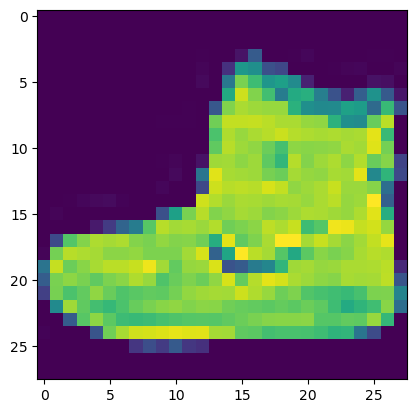

In [94]:
plt.imshow(image.squeeze())

But our dataset is in grayscale. So will convert to grayscale.

Text(0.5, 1.0, 'Ankle boot')

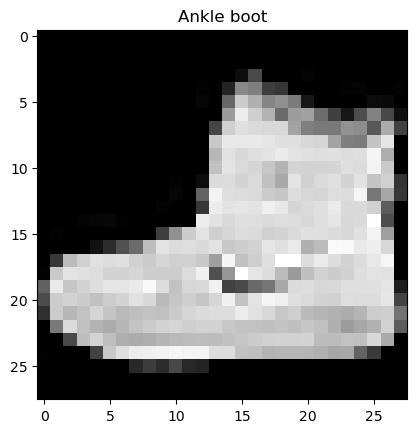

In [95]:
plt.imshow(image.squeeze(), cmap='gray')
plt.title(class_names[label])

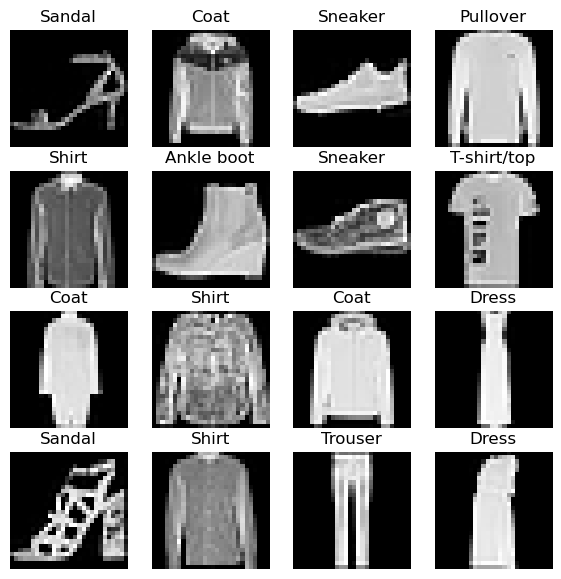

In [96]:
#View more images
fig = plt.figure(figsize=(7,7))
rows, cols = 4,4
for i in range(1, rows*cols + 1):
    rand = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[rand]
    fig.add_subplot(rows, cols, i)
    plt.title(class_names[label])
    plt.imshow(img.squeeze(), cmap='gray')
    plt.axis(False)

## Model Building

`DataLoader` is used to load the data to the model. It turn the dataset into a iterable of smaller data (batch size).

In [97]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    train_data, 
    batch_size=BATCH_SIZE, 
    shuffle=True # This shuffles the data that way present batch is different from before batch
)

test_dataloader = DataLoader(
    test_data,
    batch_size = BATCH_SIZE #shuffle doesn't matter
)
len(train_dataloader)


1875

1875*32 should be around `len(train_data)`

In [98]:
class ModelOne(nn.Module):
    def __init__(self, input_shape: int, hidden_shape: int, output_shape: int) -> None:
        super().__init__()

        self.layers = nn.Sequential(
            nn.Flatten(), #Explnation in below markdown
            nn.Linear(in_features=input_shape, out_features=hidden_shape),
            nn.ReLU(),
            nn.Linear(in_features=hidden_shape, out_features=output_shape),
            nn.ReLU()
        )
    
    def forward(self, X: torch.Tensor):
        return self.layers(X)

`nn.Flatten` makes the input into a single dimnesion by multiplying all other leaving the first dimension. Ex: Our input image is (1,28,28). Flatten wi;; return (1, 28*28) i.e (1,784).

As flatten outputs 784 as the second dim, `input_shape` = 784. `hidden_shape` is hyperprameter which represents number if nodes in each layer and `output_shape` is equal number of labels to be classified which in our case is 10 (len(class_names)).

In [99]:
model_1 = ModelOne(784, 10, len(class_names)).to(device) #Running on gpu if avail
next(model_1.parameters()).device

device(type='cuda', index=0)

In [100]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)
accuracy = Accuracy(task='multiclass', num_classes=10).to(device)


In [101]:
accuracy.device

device(type='cuda', index=0)

Will write a common train and test functions we can reuse for later models

In [102]:
def train_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn,
    optimizer: torch.optim.Optimizer,
    device: torch.device = device #Default is gpu if avail
):
    train_loss = 0
    model.train() #Not mandatory as default is train
    #Data_Loader outputs X and y in batches
    for batch, (X_train,y_train) in enumerate(data_loader):
        #Use gpu if avail
        X_train, y_train = X_train.to(device), y_train.to(device)
        #Forward
        y_train_pred = model(X_train)
        #Loss
        loss = loss_fn(y_train_pred, y_train)
        train_loss += loss
        #backpropogation
        loss.backward()
        #Optimization
        optimizer.step()
        #Zero out the graidents
        optimizer.zero_grad()
        #Metric
        batch_acc = accuracy(y_train_pred.softmax(dim=1), y_train)
        #print(f"Accuracy of batch {batch} is {batch_acc} and loss is {loss}")
    train_acc = accuracy.compute()
    train_loss /= len(data_loader)
    print(f"Accuracy={train_acc} and loss={train_loss}")


In [103]:
def test_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn,
    device: torch.device = device
):
    test_loss = 0
    model.eval()
    with torch.inference_mode(): #Dont track derivates
        for X_test,y_test in data_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            #Forward
            y_test_pred = model(X_test)
            #loss
            loss = loss_fn(y_test_pred, y_test)
            #Metrics
            test_loss += loss
            acc = accuracy(y_test_pred.softmax(dim=1), y_test)
            
        test_acc = accuracy.compute()
        test_loss /= len(data_loader)
        print(f"Accuracy={test_acc} and loss={test_loss}")

Training and testing `model_1`

In [104]:
epochs = 3
for epoch in range(epochs):
    print(f"Epoch{epoch} Training")
    train_step(
        model_1,
        train_dataloader,
        loss_fn,
        optimizer
    )
    print(f"Epoch{epoch} Testing")
    test_step(
        model_1,
        test_dataloader,
        loss_fn
    )

Epoch0 Training
Accuracy=0.5177666544914246 and loss=1.4015069007873535
Epoch0 Testing
Accuracy=0.5232714414596558 and loss=1.2759325504302979
Epoch1 Training
Accuracy=0.5418077111244202 and loss=1.265391230583191
Epoch1 Testing
Accuracy=0.5429357290267944 and loss=1.2766042947769165
Epoch2 Training
Accuracy=0.5502849817276001 and loss=1.2523777484893799
Epoch2 Testing
Accuracy=0.5511618852615356 and loss=1.252095103263855


Model 2 (CNN model)